In [1]:
import logging

from src.common.globals import G
from src.common.plots import Visualize as V
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info
from src.features.build_features import FeatureEngineering as FE

from src.models_service.models_service import TensorflowDataPreparation as TFDataPrep
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.models_service.errors import ErrorsCalculation as ErrorCalc


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

DATA_DIR_PROCESSED = G.processed_daily_full_dir

config = {
    'AV': {
        'key': '',
        'ticker': 'VGT',
    },
    'data': {
        'test_size': 0.05,
    },

    'model_name': 'VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17',
}

2023-10-22 04:07:53.654457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 04:07:53.654512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 04:07:53.654571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 04:07:53.678095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)
df = FE.create_features(df, logger)
_, df_test = TFDataPrep.split_train_test(df, config['data']['test_size'], logger)

df_test_X = df_test.drop(columns=['Adj Close'])
df_test_X = FE.rename_shifted_columns(df_test_X)
df_test_y = df_test['Adj Close']

#------------------------Load the model if necessary--------------------------
model_scaler_name = config['model_name']

model = TFModelService.load_model(model_name=model_scaler_name, logger=logger)
scalers_X = TFModelService.load_scalers(model_name=model_scaler_name, logger=logger)
window_size = TFModelService.get_window_size_from_model_name(model._name)

2023-10-22 04:07:55 - src.data.get_data - INFO - Loaded "../P7-Trading-Bot/data/03_processed/daily_full". Number data points 4965. From "2004-01-30 00:00:00" to "2023-10-19 00:00:00"
2023-10-22 04:07:55 - __main__ - INFO - --------------------create_features() - shift(1)--------------------
2023-10-22 04:07:55 - __main__ - INFO - df.shape: (4964, 3)


2023-10-22 04:07:55 - __main__ - INFO - df.columns: Index(['Adj Close', 'Adj Close - 1', 'Volume - 1'], dtype='object')
2023-10-22 04:07:55 - __main__ - INFO - df_train.shape: (4716, 3), df_test.shape: (248, 3)
2023-10-22 04:07:55 - __main__ - INFO - Last record in df_train:
Adj Close           321.461639
Adj Close - 1       317.713220
Volume - 1       483346.000000
Name: 2022-10-24 00:00:00, dtype: float64
2023-10-22 04:07:55 - __main__ - INFO - Last record in df_test:
Adj Close           417.24
Adj Close - 1       420.23
Volume - 1       318303.00
Name: 2023-10-19 00:00:00, dtype: float64
2023-10-22 04:07:55 - __main__ - INFO - First record in df_test:
Adj Close           328.502320
Adj Close - 1       321.461639
Volume - 1       461745.000000
Name: 2022-10-25 00:00:00, dtype: float64
2023-10-22 04:07:55.857973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may ha

2023-10-22 04:08:00.718630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


229/229 [==============================] - 3s 5ms/step


2023-10-22 04:08:02.153604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13388273856354525732
2023-10-22 04:08:02 - src.common.plots - INFO - Plot "Predictions VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17-VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17.png" saved to "/workspaces/P7-Trading-Bot/figures/Predictions VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17-VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17.png"


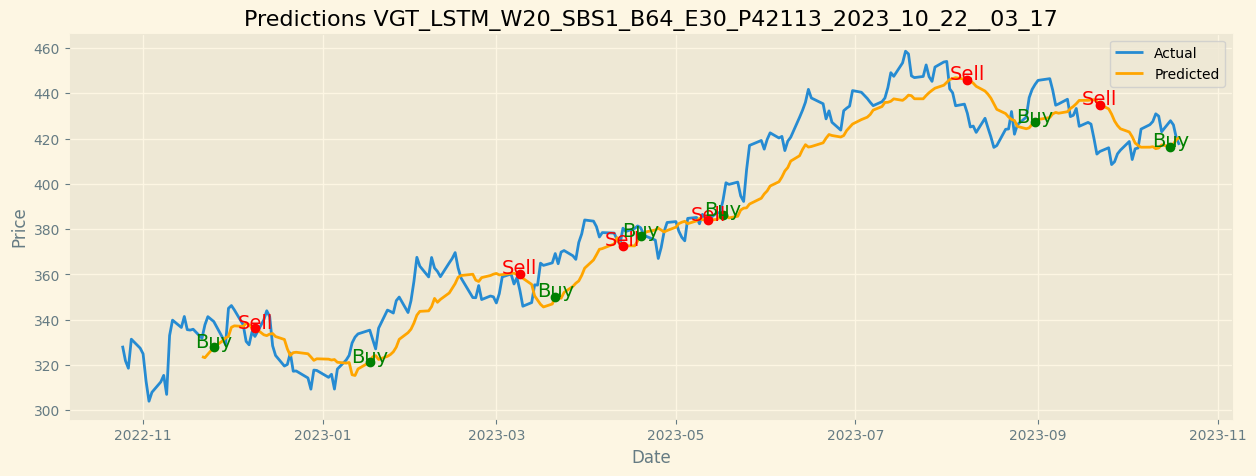

'/workspaces/P7-Trading-Bot/figures/Predictions VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17-VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17.png'

In [3]:
# -----------------------------Predictions-----------------------------------
results = TFModelService.model_forecast(model=model, 
                                        df=df_test_X,
                                        window_size=window_size,
                                        scalers=scalers_X,
                                        verbose=False)


V.plot_series(  x=(df_test_y.index, df_test_y.index[window_size-1:]), 
                y=(df_test_y, results),
                model_name=model._name,
                signal = True,
                title=f'Predictions {model._name}',
                xlabel='Date',
                ylabel='Price',
                legend=['Actual', 'Predicted'],
                show=True)

In [4]:
# -----------------------Calculate Errors----------------------------------
df_test_y_no_window = df_test_y.iloc[window_size-1:]      # actual values without window size in the beginning

naive_forecast = ErrorCalc.get_naive_forecast(df).loc[df_test_y_no_window.index] 
rmse, mae, mape, mase = ErrorCalc.calc_errors(df_test_y_no_window, results, naive_forecast)
ErrorCalc.save_errors_to_table(model._name, {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-10-22 04:08:02 - src.models_service.errors - INFO - Test RMSE: $ 12.157
2023-10-22 04:08:02 - src.models_service.errors - INFO - Test MAE : $ 10.332
2023-10-22 04:08:02 - src.models_service.errors - INFO - Test MAPE:   0.027
2023-10-22 04:08:02 - src.models_service.errors - INFO - Test MASE:   2.532
2023-10-22 04:08:02 - src.models_service.errors - INFO - Errors saved to for VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17 model to "logs/models_table.csv" file.


/workspaces/P7-Trading-Bot/models_trained
